# Response analysis


##### 1. Response expression differential analysis - 
twice: (1) tumor cells and (2) immune cells separately - finds markers across all (protein coding) genes and draw heatmaps. - DONE

##### 2. Response association with clusters analysis - 
Each cluster see the number of cells correspond to response patients vs. number of cells corespond to non-response patients.

##### 3. GEP association with response (1) -
Per program, take all usage values of cells coming from R patients vs. NR patients, and perform Wilcoxon ranksum test.

##### 4. GEP association with response (2) - 
Assign each cell one program based on the maximal usage value. Then, for each patient, compute the fraction of cells belonging to each program. Finally, you can perform wilcoxon per program, comparing these fractions between R and NR patients.


In [1]:
lib = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/'
import sys
sys.path.append(lib)
from utilities.package_importing import *

Helper functions:

In [2]:
def print_pvals(pvals, n_groups):
    
    pvals_df = pd.DataFrame([[v[0], int(v[1])] for v in transpose([pvals, range(1, n_groups+1)])], columns=['pval', 'group'])
    plt.figure(figsize=(8, 6), dpi=80);

    pvals = pvals_df[["group", "pval"]].values
    small_pvals = pvals[pvals[:,1]<0.05]
    big_pvals = pvals[pvals[:,1]>=0.05]


    plt.scatter(x=big_pvals[:,0], y=big_pvals[:,1]);
    plt.scatter(x=small_pvals[:,0], y=small_pvals[:,1]);

    ax = plt.plot([0,n_groups+1],[0.05,0.05], color='y');
    plt.xticks(np.arange(1, n_groups+1));
    plt.yticks([0.05, 1]);
    plt.xlim((0,n_groups+1));
    plt.title('p-values');

    for coord in pvals:
        plt.text(coord[0], coord[1], '{}'.format(int(coord[0])));

##### Loads clinical table to get labels - R/NR

In [3]:
melanoma_clinical_data = get_clinical_data(71)#ICI=True, after_biopsy='ICI')
res_melanoma_clinical_data = melanoma_clinical_data.set_index('Patient id')
melanoma_clinical_data.head(5)

Using clinical table in path:
 /storage/md_keren/shitay/Data/tables/Melanoma_clinical_data_OCT_unportected.xlsx

and labels:
/storage/md_keren/shitay/Data/tables/clinical_labels.xlsx


,Patient id,Melanoma type,response,prior to biopsy,after biopsy,ICI
0,M97,Cutaneous,R,nothing,ICI,True
1,M98,Cutaneous,R,ICI,other therapy,True
2,M99,Mucosal,NR,ICI,other immune therapy,True
3,M100,Cutaneous,NR,ICI,nothing,True
4,M101,other,R,nothing,ICI,True


#### Builds response/non_response sample list

In [4]:
response_samples = melanoma_clinical_data[melanoma_clinical_data['response'] == 'R']['Patient id'].tolist()
non_response_samples = melanoma_clinical_data[melanoma_clinical_data['response'] == 'NR']['Patient id'].tolist()
no_used_samples = melanoma_clinical_data[melanoma_clinical_data['response'] == 'not in use for now']['Patient id'].tolist()

print(f'number reponse_samples: {len(response_samples)}')
print(f'number non_reponse_samples: {len(non_response_samples)}')
print(f'number no label samples: {len(no_used_samples)}')

number reponse_samples: 20
number non_reponse_samples: 32
number no label samples: 19


#### Loads tumor & immune cohort:

In [134]:
# tumor_path = r'/storage/md_keren/shitay/Data/droplet_seq/cohort/normalized/5.21/cohort_normalized_24.5.21.pkl'
# COHORT_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/cohort/normalized/6.21/cohort_normalized_26.6.21.pkl'
COHORT_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/M97_M173/cohort/normalized/4.11.21/cohort_normalized_4.11.21_protein_coding_genes.pkl'

# tumor_cohort = pickle.load(open(tumor_path, 'rb'))
cohort = pickle.load(open(COHORT_PATH, 'rb'))
tumor_cohort = cohort.filter_cells_by_property('is_cancer', True)
immune_cohort = cohort.filter_cells_by_property('is_immune', True)



#  1. Response differential expression analysis

(1) tumor cells and (2) immune cells separately - finds markers across all (protein coding) genes and draw heatmaps. - DONE

## Tumor -  differential expression analysis

In [138]:
response_samples_indices = [s in response_samples for s in tumor_cohort.samples]
non_response_samples_indices =[s in non_response_samples for s in tumor_cohort.samples]
no_used_samples_indices = [s in no_used_samples for s in tumor_cohort.samples]

print(f'number of cells in response_samples_indices: {sum(response_samples_indices)}')
print(f'number of cells in non_response_samples_indices: {sum(non_response_samples_indices)}')
print(f'number of cells in no_used_samples_indices: {sum(no_used_samples_indices)}')

response_samples_tumor_cells = tumor_cohort[response_samples_indices]
non_response_samples_tumor_cells = tumor_cohort[non_response_samples_indices]

number of cells in response_samples_indices: 33406
number of cells in non_response_samples_indices: 83006
number of cells in no_used_samples_indices: 41321


#### Conduct fisher's exact test to find markers of response in tumor cells:

In [139]:
# from utilities.clustering_tools import find_marker_genes_in_cluster
response_markers = find_marker_genes_in_cluster(response_samples_tumor_cells, non_response_samples_tumor_cells, log_FC_threshold=0.05, pval_threshold=0.05, min_pct=0.1, min_diff_pct=0.1)

#### Conduct fisher's exact test to find markers of non-response in tumor cells:

In [140]:
non_response_markers = find_marker_genes_in_cluster(non_response_samples_tumor_cells, response_samples_tumor_cells, log_FC_threshold=0.05, pval_threshold=0.05, min_pct=0.1, min_diff_pct=0.1)

#### Builds heatmap:

In [141]:
number_of_markers = 50

In [142]:
# arrange cells indices by mean expression
response_markers_indices = np.array([tumor_cohort.features.index(f) for f in response_markers.iloc[:number_of_markers]['features']])
response_cells_indices = np.flip(np.argsort(response_samples_tumor_cells.counts[:, response_markers_indices].mean(axis=1)))

non_response_markers_indices = [tumor_cohort.features.index(f) for f in non_response_markers.iloc[:number_of_markers]['features']]
non_response_cells_indices = np.flip(np.argsort(non_response_samples_tumor_cells.counts[:, non_response_markers_indices].mean(axis=1)))

In [143]:
genes_indices = [tumor_cohort.features.index(f) for f in response_markers.iloc[:number_of_markers]['features']] + [tumor_cohort.features.index(f) for f in non_response_markers.iloc[:number_of_markers]['features']]
arr_heatmap = np.concatenate([response_samples_tumor_cells.counts[response_cells_indices][:, genes_indices], non_response_samples_tumor_cells.counts[non_response_cells_indices][:, genes_indices]])
heatmap = np.zeros_like(arr_heatmap)
heatmap[arr_heatmap > 1] = 1
arr_heatmap = scipy.stats.zscore(arr_heatmap, axis=0, ddof=1)

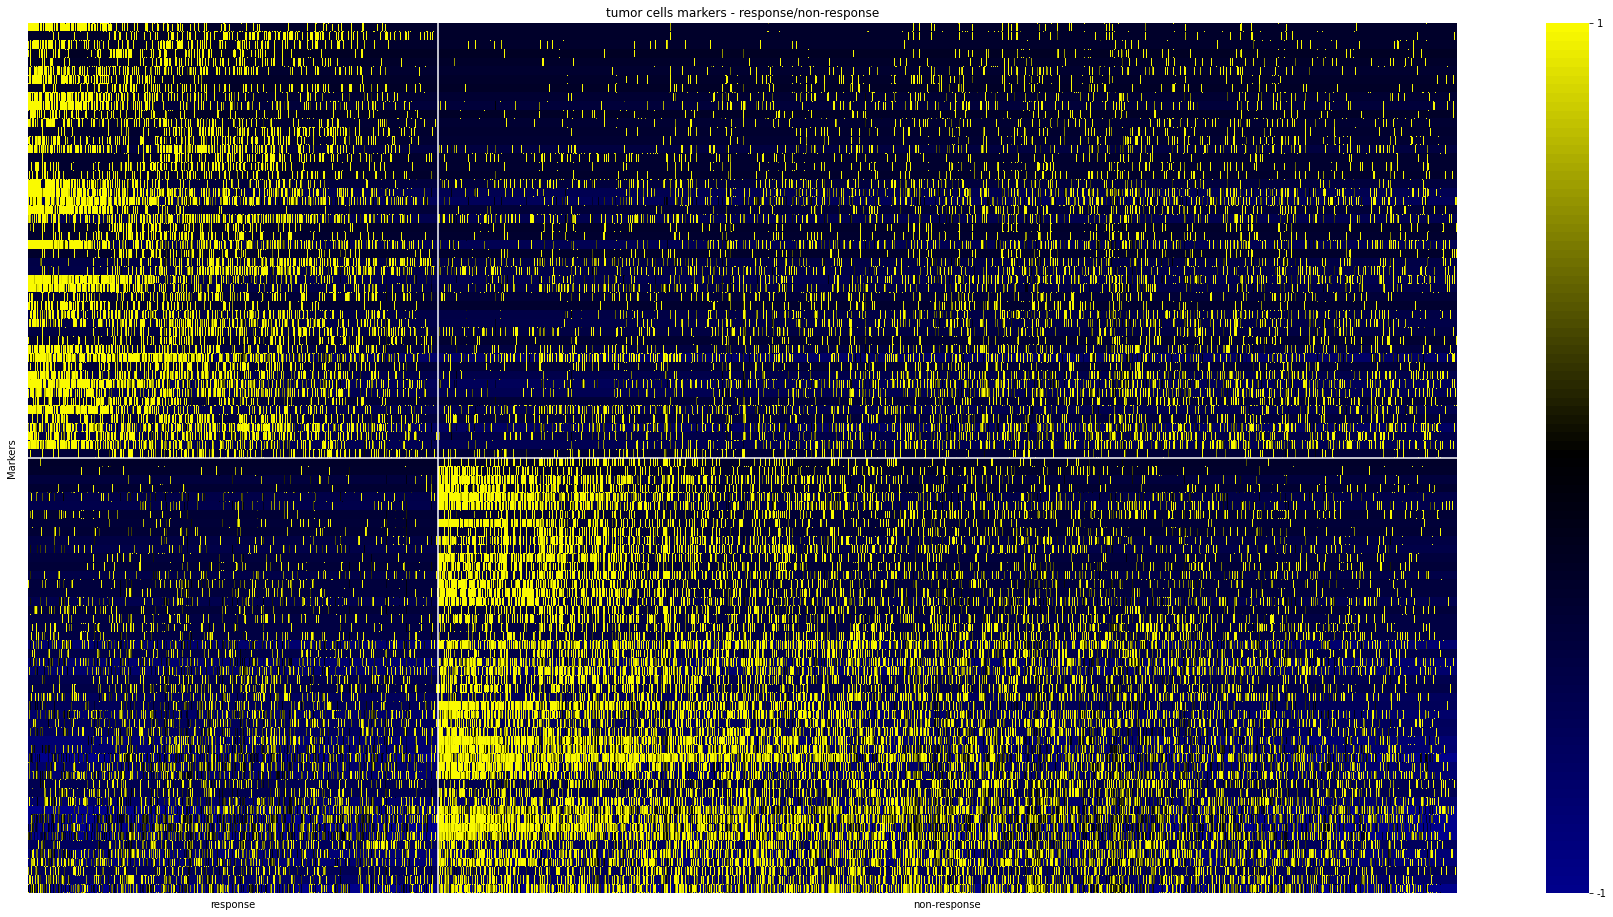

In [146]:
cmap = pickle.load(open(r'/storage/md_keren/shitay/outputs/clustering/immune/heatmap/colorbar.pkl', 'rb'))
fig, ax = plt.subplots(1)
# fig.set_size_inches(10, 5)
fig.set_size_inches(32, 16)

sb_out = sb.heatmap(arr_heatmap.T, vmin=-1, vmax=1, cmap=cmap);
cbar = sb_out.collections[0].colorbar
cbar.set_ticks([-1, 1])
cbar.set_ticklabels([-1, 1])


sb_out.set_xticks([int(response_samples_tumor_cells.number_of_cells/2), response_samples_tumor_cells.number_of_cells+int(non_response_samples_tumor_cells.number_of_cells/2) ]) # <--- set the ticks first
sb_out.set_xticklabels(['response', 'non-response'], rotation='horizontal')


# sb_out.set(xticklabels=[])
sb_out.set(yticklabels=[])
sb_out.tick_params(bottom=False, left=False)

ax.axhline(number_of_markers, color='white')
ax.axvline(response_samples_tumor_cells.number_of_cells, color='white')
ax.set_title(f"tumor cells markers - response/non-response");
# ax.set_xlabel('response            non-response');
ax.set_ylabel('Markers');

In [147]:
FOLDER_PATH = r'/storage/md_keren/shitay/outputs/response_analysis/cohort_4.11.21'
FILE_NAME = r'tumor_cells_marker_heatmap.png'

create_folder(FOLDER_PATH)
fig.savefig(join(FOLDER_PATH, FILE_NAME))
response_markers.to_excel(join(FOLDER_PATH, r'response_tumor_markers.xlsx'))
non_response_markers.to_excel(join(FOLDER_PATH, r'non_response_tumor_markers.xlsx'))

folder: /storage/md_keren/shitay/outputs/response_analysis/cohort_4.11.21 has been created


## Immune - differential expression analysis

In [148]:
response_samples_indices = [s in response_samples for s in immune_cohort.samples]
non_response_samples_indices =[s in non_response_samples for s in immune_cohort.samples]
no_used_samples_indices = [s in no_used_samples for s in immune_cohort.samples]

print(f'number of cells in response_samples_indices: {sum(response_samples_indices)}')
print(f'number of cells in non_response_samples_indices: {sum(non_response_samples_indices)}')
print(f'number of cells in no_used_samples_indices: {sum(no_used_samples_indices)}')

response_samples_immune_cells = immune_cohort[response_samples_indices]
non_response_samples_immune_cells = immune_cohort[non_response_samples_indices]

number of cells in response_samples_indices: 48453
number of cells in non_response_samples_indices: 44845
number of cells in no_used_samples_indices: 51279


##### Conduct fisher's exact test to find markers of response in immune cells:

In [156]:
# from utilities.clustering_tools import find_marker_genes_in_cluster
immune_response_markers = find_marker_genes_in_cluster(response_samples_immune_cells, non_response_samples_immune_cells, log_FC_threshold=0.025, pval_threshold=0.05, min_pct=0.05, min_diff_pct=0.025)

##### Conduct fisher's exact test to find markers of response in immune cells:

In [150]:
immune_non_response_markers = find_marker_genes_in_cluster(non_response_samples_immune_cells, response_samples_immune_cells, log_FC_threshold=0.05, pval_threshold=0.05, min_pct=0.1, min_diff_pct=0.05)

##### Builds heatmap:

In [161]:
number_of_markers = 30

In [162]:
# arrange cells indices by mean expression
response_markers_indices = np.array([immune_cohort.features.index(f) for f in immune_response_markers.iloc[:number_of_markers]['features']])
response_cells_indices = np.flip(np.argsort(response_samples_immune_cells.counts[:, response_markers_indices].mean(axis=1)))

non_response_markers_indices = [immune_cohort.features.index(f) for f in immune_non_response_markers.iloc[:number_of_markers]['features']]
non_response_cells_indices = np.flip(np.argsort(non_response_samples_immune_cells.counts[:, non_response_markers_indices].mean(axis=1)))

In [163]:
genes_indices = [immune_cohort.features.index(f) for f in immune_response_markers.iloc[:number_of_markers]['features']] + [immune_cohort.features.index(f) for f in immune_non_response_markers.iloc[:number_of_markers]['features']]
arr_heatmap = np.concatenate([response_samples_immune_cells.counts[response_cells_indices][:, genes_indices], non_response_samples_immune_cells.counts[non_response_cells_indices][:, genes_indices]])
heatmap = np.zeros_like(arr_heatmap)
heatmap[arr_heatmap > 1] = 1
arr_heatmap = scipy.stats.zscore(arr_heatmap, axis=0, ddof=1)

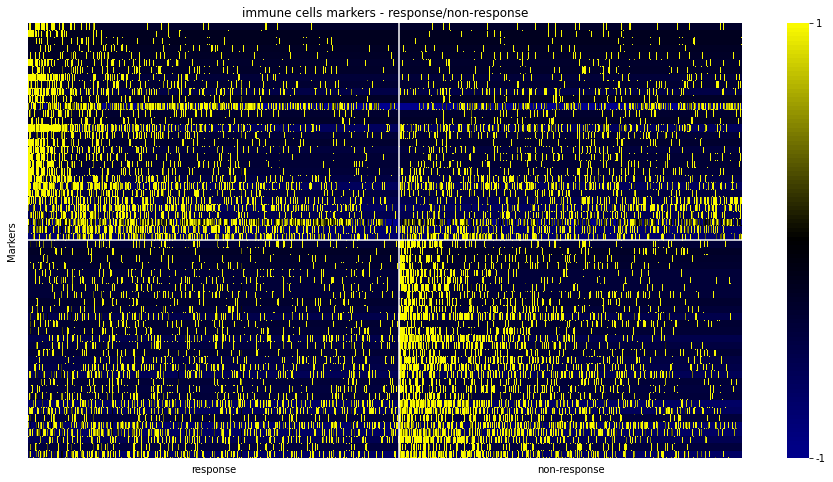

In [165]:
cmap = pickle.load(open(r'/storage/md_keren/shitay/outputs/clustering/immune/heatmap/colorbar.pkl', 'rb'))
fig, ax = plt.subplots(1)
fig.set_size_inches(16, 8)

sb_out = sb.heatmap(arr_heatmap.T, vmin=-1, vmax=1, cmap=cmap);
cbar = sb_out.collections[0].colorbar
cbar.set_ticks([-1, 1])
cbar.set_ticklabels([-1, 1])


sb_out.set_xticks([int(response_samples_immune_cells.number_of_cells/2), response_samples_immune_cells.number_of_cells+int(non_response_samples_immune_cells.number_of_cells/2) ]) # <--- set the ticks first
sb_out.set_xticklabels(['response', 'non-response'], rotation='horizontal')


# sb_out.set(xticklabels=[])
sb_out.set(yticklabels=[])
sb_out.tick_params(bottom=False, left=False)

ax.axhline(number_of_markers, color='white')
ax.axvline(response_samples_immune_cells.number_of_cells, color='white')
ax.set_title(f"immune cells markers - response/non-response");
# ax.set_xlabel('response            non-response');
ax.set_ylabel('Markers');

In [170]:
FOLDER_PATH = r'/storage/md_keren/shitay/outputs/response_analysis/cohort_4.11.21'
FILE_NAME = r'immune_cells_marker_heatmap.png'

create_folder(FOLDER_PATH)
fig.savefig(join(FOLDER_PATH, FILE_NAME))
immune_response_markers.to_excel(join(FOLDER_PATH, r'response_immune_markers.xlsx'))
immune_non_response_markers.to_excel(join(FOLDER_PATH, r'non_response_immune_markers.xlsx'))

# 2. Response association with clusters analysis

For each cluster, see the number of cells correspond to response patients vs. number of cells corespond to non-response patients.


In [115]:
# clusters_barcodes_mapping_path = r'/storage/md_keren/shitay/outputs/clustering/immune/summaries/26.6.21/immune_kmeans_26.6.21_clusters_mapping.csv'
clusters_barcodes_mapping_path = r'/storage/md_keren/shitay/outputs/clustering/immune/summaries/4.11.21/immune_kmeans_integrated_4.11.21_clusters_mapping.csv'
clusters_barcodes_mapping_df = pd.read_csv(clusters_barcodes_mapping_path)

##### Takes only samples that appear in the clinical table

In [116]:
clusters_barcodes_mapping_df = clusters_barcodes_mapping_df[clusters_barcodes_mapping_df["Sample"].isin(melanoma_clinical_data['Patient id'])]

###### cluster visualizations

In [117]:
df = clusters_barcodes_mapping_df#.drop(columns=['index'])
df['Response'] = df['Sample'].apply(lambda x: res_melanoma_clinical_data.loc[x]['response'])

n_NR = df['Response'].value_counts()['NR']
n_R = df['Response'].value_counts()['R']

In [118]:
clusters = df['Cluster'].unique()

NR_counts = np.zeros(len(clusters))
R_counts = np.zeros(len(clusters))

for idx, cluster in enumerate(clusters):
    responses = df[df['Cluster']==cluster]['Response']
    NR_counts[idx] = sum(responses=='NR')
    R_counts[idx] = sum(responses=='R')


RanksumsResult(statistic=1.8475208614068022, pvalue=0.06467168750236378)
WilcoxonResult(statistic=14.0, pvalue=0.05224609375)


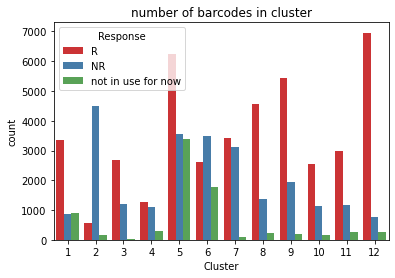

In [119]:
# for idx, (cx, cy) in enumerate(list(zip(NR_counts, R_counts))):
#     print(f'cluster {idx+1} -  NR: {int(cx)}, R: {int(cy)}')

sns.reset_orig() # reset size of figure
ax = sns.countplot(x="Cluster", hue='Response', data=df, palette="Set1").set(title='number of barcodes in cluster')

print()
print(ranksums(R_counts, NR_counts))
print(wilcoxon(R_counts, NR_counts))

##### Normalized by group size (number of barcodes in group - R/NR):

Normalized by number of barcodes in group (R/NR):

RanksumsResult(statistic=0.404145188432738, pvalue=0.6861059569955559)
WilcoxonResult(statistic=35.0, pvalue=0.791015625)


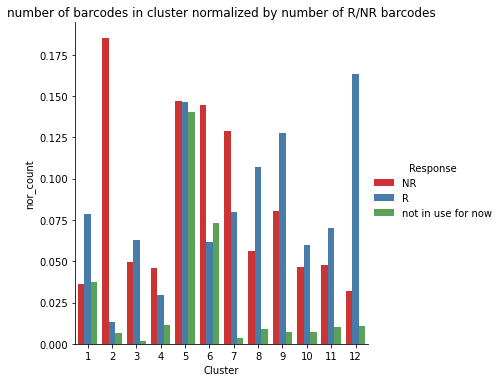

In [120]:
R_nor = R_counts/n_R
NR_nor = NR_counts/n_NR

print('Normalized by number of barcodes in group (R/NR):')
# for idx, (cx, cy) in enumerate(list(zip(NR_nor, R_nor))):
#     print(f'cluster {idx+1} -  NR: {round(cx,3)}, R: {round(cy,3)}')

count_df = df.groupby(['Response', 'Cluster']).count().reset_index().rename(columns={'Sample': 'count'}).drop(columns=['Barcode'])
count_df["nor_count"] = count_df.apply(lambda x: x['count']/n_R if x['Response']=='R' else x['count']/n_NR ,axis=1)
ax = sns.catplot(kind="bar", x='Cluster', y='nor_count', hue='Response', data=count_df, palette="Set1").set(title='number of barcodes in cluster normalized by number of R/NR barcodes')
    
print()
print(ranksums(R_nor, NR_nor))
print(wilcoxon(R_nor, NR_nor))

##### Normalized by number of cells in cluster:


RanksumsResult(statistic=2.6558112382722783, pvalue=0.007911788680711459)
WilcoxonResult(statistic=14.0, pvalue=0.05224609375)


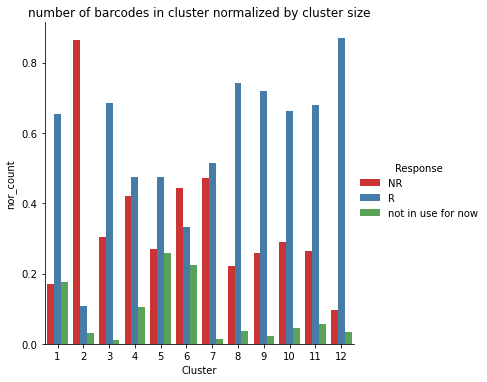

In [121]:
NR_nor = NR_counts/(NR_counts + R_counts)
R_nor = R_counts/(NR_counts + R_counts)

# print('Normalized by number of barcodes in cluster:')
# for idx, (cx, cy) in enumerate(list(zip(NR_nor, R_nor))):
#     print(f'cluster {idx+1} -  NR: {round(cx,3)}, R: {round(cy,3)}')
    
df_nor_count = df.groupby(['Response', 'Cluster']).count().reset_index().rename(columns={'Sample': 'count'}).drop(columns=['Barcode'])
# df_nor_count = df[df["Response"]!= 'not in use for now'].groupby(['Response', 'Cluster']).count().reset_index().rename(columns={'Sample': 'count'}).drop(columns=['Barcode'])
df_nor_count['nor_count'] = df_nor_count.apply(lambda x: x['count']/df_nor_count[df_nor_count['Cluster']==x['Cluster']]['count'].sum(), axis=1)
ax = sns.catplot(kind="bar", x='Cluster', y='nor_count', hue='Response', data=df_nor_count, palette="Set1").set(title='number of barcodes in cluster normalized by cluster size')
print()    
print(ranksums(R_nor, NR_nor))
print(wilcoxon(R_nor, NR_nor))

#### patient fraction over clusters

In [122]:
sample_fractions_df = clusters_barcodes_mapping_df.groupby(['Sample', 'Cluster']).count().reset_index()#.drop(columns=['index'])
sample_counts_df = clusters_barcodes_mapping_df.groupby(['Sample']).count().reset_index().drop(columns=['Cluster'])#.drop(columns=['index'])
sample_fractions_df
sample_fractions_df['counts'] = sample_fractions_df.apply(lambda x: sample_counts_df.set_index('Sample').loc[x['Sample']][0], axis=1)
sample_fractions_df['fraction'] = sample_fractions_df['Barcode'] / sample_fractions_df['counts'] 
sample_fractions_df['Response'] = sample_fractions_df['Sample'].apply(lambda x: res_melanoma_clinical_data.loc[x]['response'])

See how many samples (R/NR) have cells in each cluster:

In [127]:
# sample_fractions_df[["Sample", 'Cluster']].groupby('Cluster').count()
# sample_fractions_df[["Sample", 'Cluster', 'Response']].groupby(['Cluster','Response']).count()

Add zero fraction samples to DF:

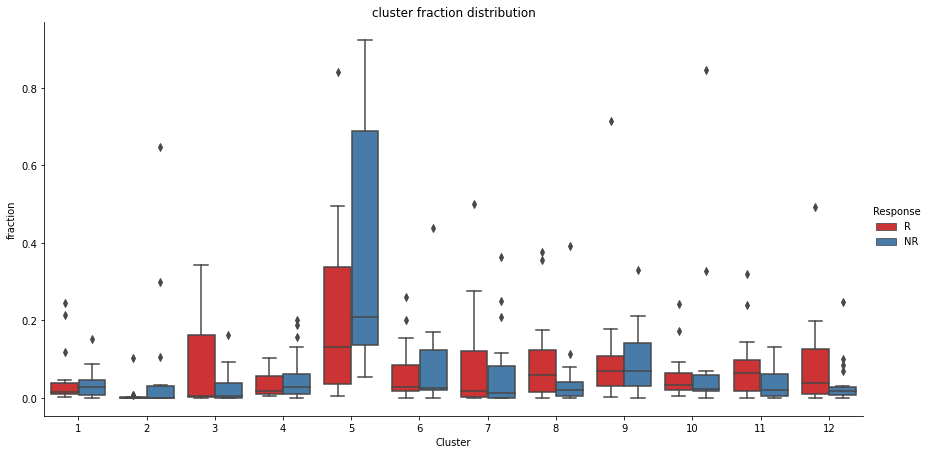

<Figure size 480x240 with 0 Axes>

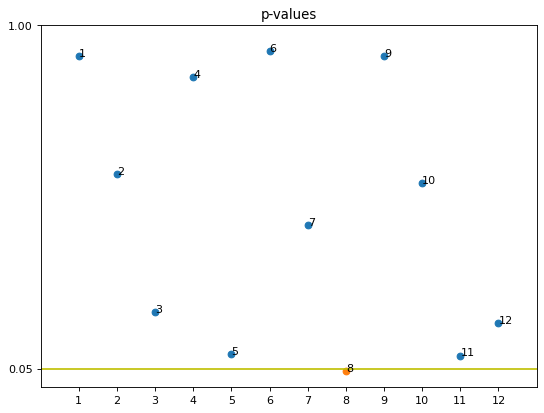

In [129]:
sample_fractions_df = sample_fractions_df[["Sample", 'Cluster', 'fraction' , 'Response' ]]
full_sample_fractions_df = pd.DataFrame(sample_fractions_df[sample_fractions_df['Response']!='not in use for now'])
samples_in_clusters = full_sample_fractions_df[["Sample", 'Cluster']].values.tolist()
samples = response_samples + non_response_samples
dic_response = {ss:'R' for ss in response_samples}
dic_response.update({ss:'NR' for ss in non_response_samples})
all_pairs = [[s, cl] for cl in clusters for s in samples]
pairs_need_to_add = [pair for pair in all_pairs if not pair in samples_in_clusters]
for sample, cluster in pairs_need_to_add:
    full_sample_fractions_df = full_sample_fractions_df.append(pd.DataFrame([[sample,cluster, 0, dic_response[sample]]], columns=full_sample_fractions_df.columns))
    
sns.reset_orig()
ax = sns.catplot(kind="box", x='Cluster', y='fraction', hue='Response', data=full_sample_fractions_df, palette="Set1",height=6, aspect=2.0).set(title="cluster fraction distribution")
plt.figure(figsize=(6, 3), dpi=80)

pvals = []
for cluster in set(sample_fractions_df["Cluster"]):
    cluster_df = full_sample_fractions_df[full_sample_fractions_df["Cluster"] == cluster]
    R_fractions = cluster_df[cluster_df["Response"] == 'R']['fraction'].values
    NR_fractions = cluster_df[cluster_df["Response"] == 'NR']['fraction'].values
    res = ranksums(R_fractions, NR_fractions)[1]
    pvals.append([cluster, res])
pvals = np.array(pvals)

# Correct pvals
# pvals[:,1] = multipletests_fdr(pvals[:,1])[1]

print_pvals(pvals[:,1], 12)
# pvals

In [133]:
# pd.set_option('display.max_rows', None)
# cluster_idx = 11
# full_sample_fractions_df[full_sample_fractions_df['Cluster']==cluster_idx].sort_values('fraction')#['Response'].tolist()

# GEP

In [11]:
EXEC_DIR = r'/storage/md_keren/shitay/outputs/cNMF/executions/tumor_runs/cohort_4.11.21'
selected_K = 30
local_density_threshold = '0.10'
number_of_genes=2000
n_replicates = 200
RUN_RANGE = '30'
N_PROG = 30
RUN_NAME = f'k{RUN_RANGE}_{number_of_genes}genes_{n_replicates}iter'
USAGES_CONSENSUS_FILE = f'{RUN_NAME}.usages.k_{selected_K}.dt_{str(local_density_threshold).replace(".", "_")}.consensus.txt'

usage_matrix = pd.read_csv(join(EXEC_DIR, RUN_NAME, USAGES_CONSENSUS_FILE), sep='\t', index_col=0)
usage_matrix.columns = np.arange(1,selected_K+1)
normalized_usage_matrix = usage_matrix.div(usage_matrix.sum(axis=1), axis=0)
# normalized_usage_matrix.head()

In [12]:
samples = list(set([uu.split('_')[0] for uu in list(normalized_usage_matrix.index)]))
df = normalized_usage_matrix.copy()
df['sample'] = [uu.split('_')[0] for uu in list(df.index)]
df['barcode'] = [uu.split('_')[1] for uu in list(df.index)]
df['Response'] = df['sample'].apply(lambda x: res_melanoma_clinical_data.loc[x]['response'])


Shows which programs are activity programs, displays the number of samples associated with each program.

In [13]:
activity_programs_df = df.copy()


cell_usage_threshold = 0.2
sample_portion_threshold = 0.2
activity_programs_df.iloc[:,:N_PROG] = activity_programs_df.iloc[:,:N_PROG] > cell_usage_threshold

sample_counts_df = activity_programs_df.groupby('sample').sum().reset_index().set_index('sample')
samples_num_barcodes = pd.DataFrame(activity_programs_df.groupby('sample')['barcode'].count()).rename(columns={'barcode':'count'})  #.agg({'barcode': ['count']}).reset_index()
sample_fraction_df = sample_counts_df.div(samples_num_barcodes.loc[sample_counts_df.index]['count'], axis=0)

# sample_fraction_df
num_of_program_in_sample = sample_fraction_df > sample_portion_threshold

activity_programs_idx = np.array(num_of_program_in_sample.columns)[num_of_program_in_sample.sum()>1].astype(int)

print(f'Number of activity programs (more than 2 samples are associated): {len(activity_programs_idx)}')
print(f'Activity programs (more than 2 samples are associated): {activity_programs_idx}')

# num_of_program_in_sample.sum()

Number of activity programs (more than 2 samples are associated): 18
Activity programs (more than 2 samples are associated): [ 2  4  6  7 10 11 13 14 17 18 19 20 21 24 25 26 28 30]


# 3. GEP association with response (1)

Per program, take all usage values of cells coming from R patients vs. NR patients, and perform Wilcoxon ranksum test.

In [14]:
df_r = df[df['Response']=='R']
df_nr = df[df['Response']=='NR']

pvals = np.zeros(selected_K)
for i in range(1, selected_K+1):
    pvals[i-1] = ranksums(df_r[i].values, df_nr[i].values)[1]

# Correct pvals
pvals = multipletests_fdr(pvals)[1].tolist()

pvals_df = pd.DataFrame([[v[0], int(v[1])] for v in transpose([pvals, range(1, selected_K+1)])], columns=['pval', 'program'])

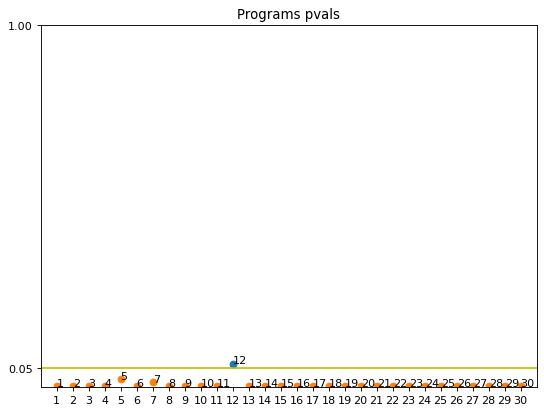

In [16]:
plt.figure(figsize=(8, 6), dpi=80)

pvals = pvals_df[["program", "pval"]].values
small_pvals = pvals[pvals[:,1]<0.05]
big_pvals = pvals[pvals[:,1]>=0.05]


plt.scatter(x=big_pvals[:,0], y=big_pvals[:,1])
plt.scatter(x=small_pvals[:,0], y=small_pvals[:,1])

ax = plt.plot([0,33],[0.05,0.05], color='y')
plt.xticks(np.arange(1, N_PROG+1));
plt.yticks([0.05, 1]);
plt.xlim((0,N_PROG+1));
plt.title('Programs pvals');

for coord in pvals:
    plt.text(coord[0], coord[1], '{}'.format(int(coord[0])))

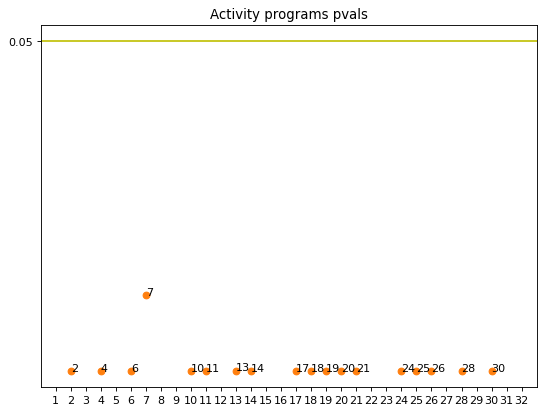

In [17]:
plt.figure(figsize=(8, 6), dpi=80)

int_prog_indxes = activity_programs_idx-1
pvals = pvals_df[["program", "pval"]].values[int_prog_indxes]
small_pvals = pvals[pvals[:,1]<0.05]
big_pvals = pvals[pvals[:,1]>=0.05]


plt.scatter(x=big_pvals[:,0], y=big_pvals[:,1])
plt.scatter(x=small_pvals[:,0], y=small_pvals[:,1])

ax = plt.plot([0,33],[0.05,0.05], color='y')
plt.xticks(np.arange(1, 33));
plt.yticks([0.05]);
plt.xlim((0,33));
plt.title('Activity programs pvals');

for coord in pvals:
    plt.text(coord[0], coord[1], '{}'.format(int(coord[0])))

#### Present Usage distribution of activity programs in different forms:

Usage distribution of activity programs


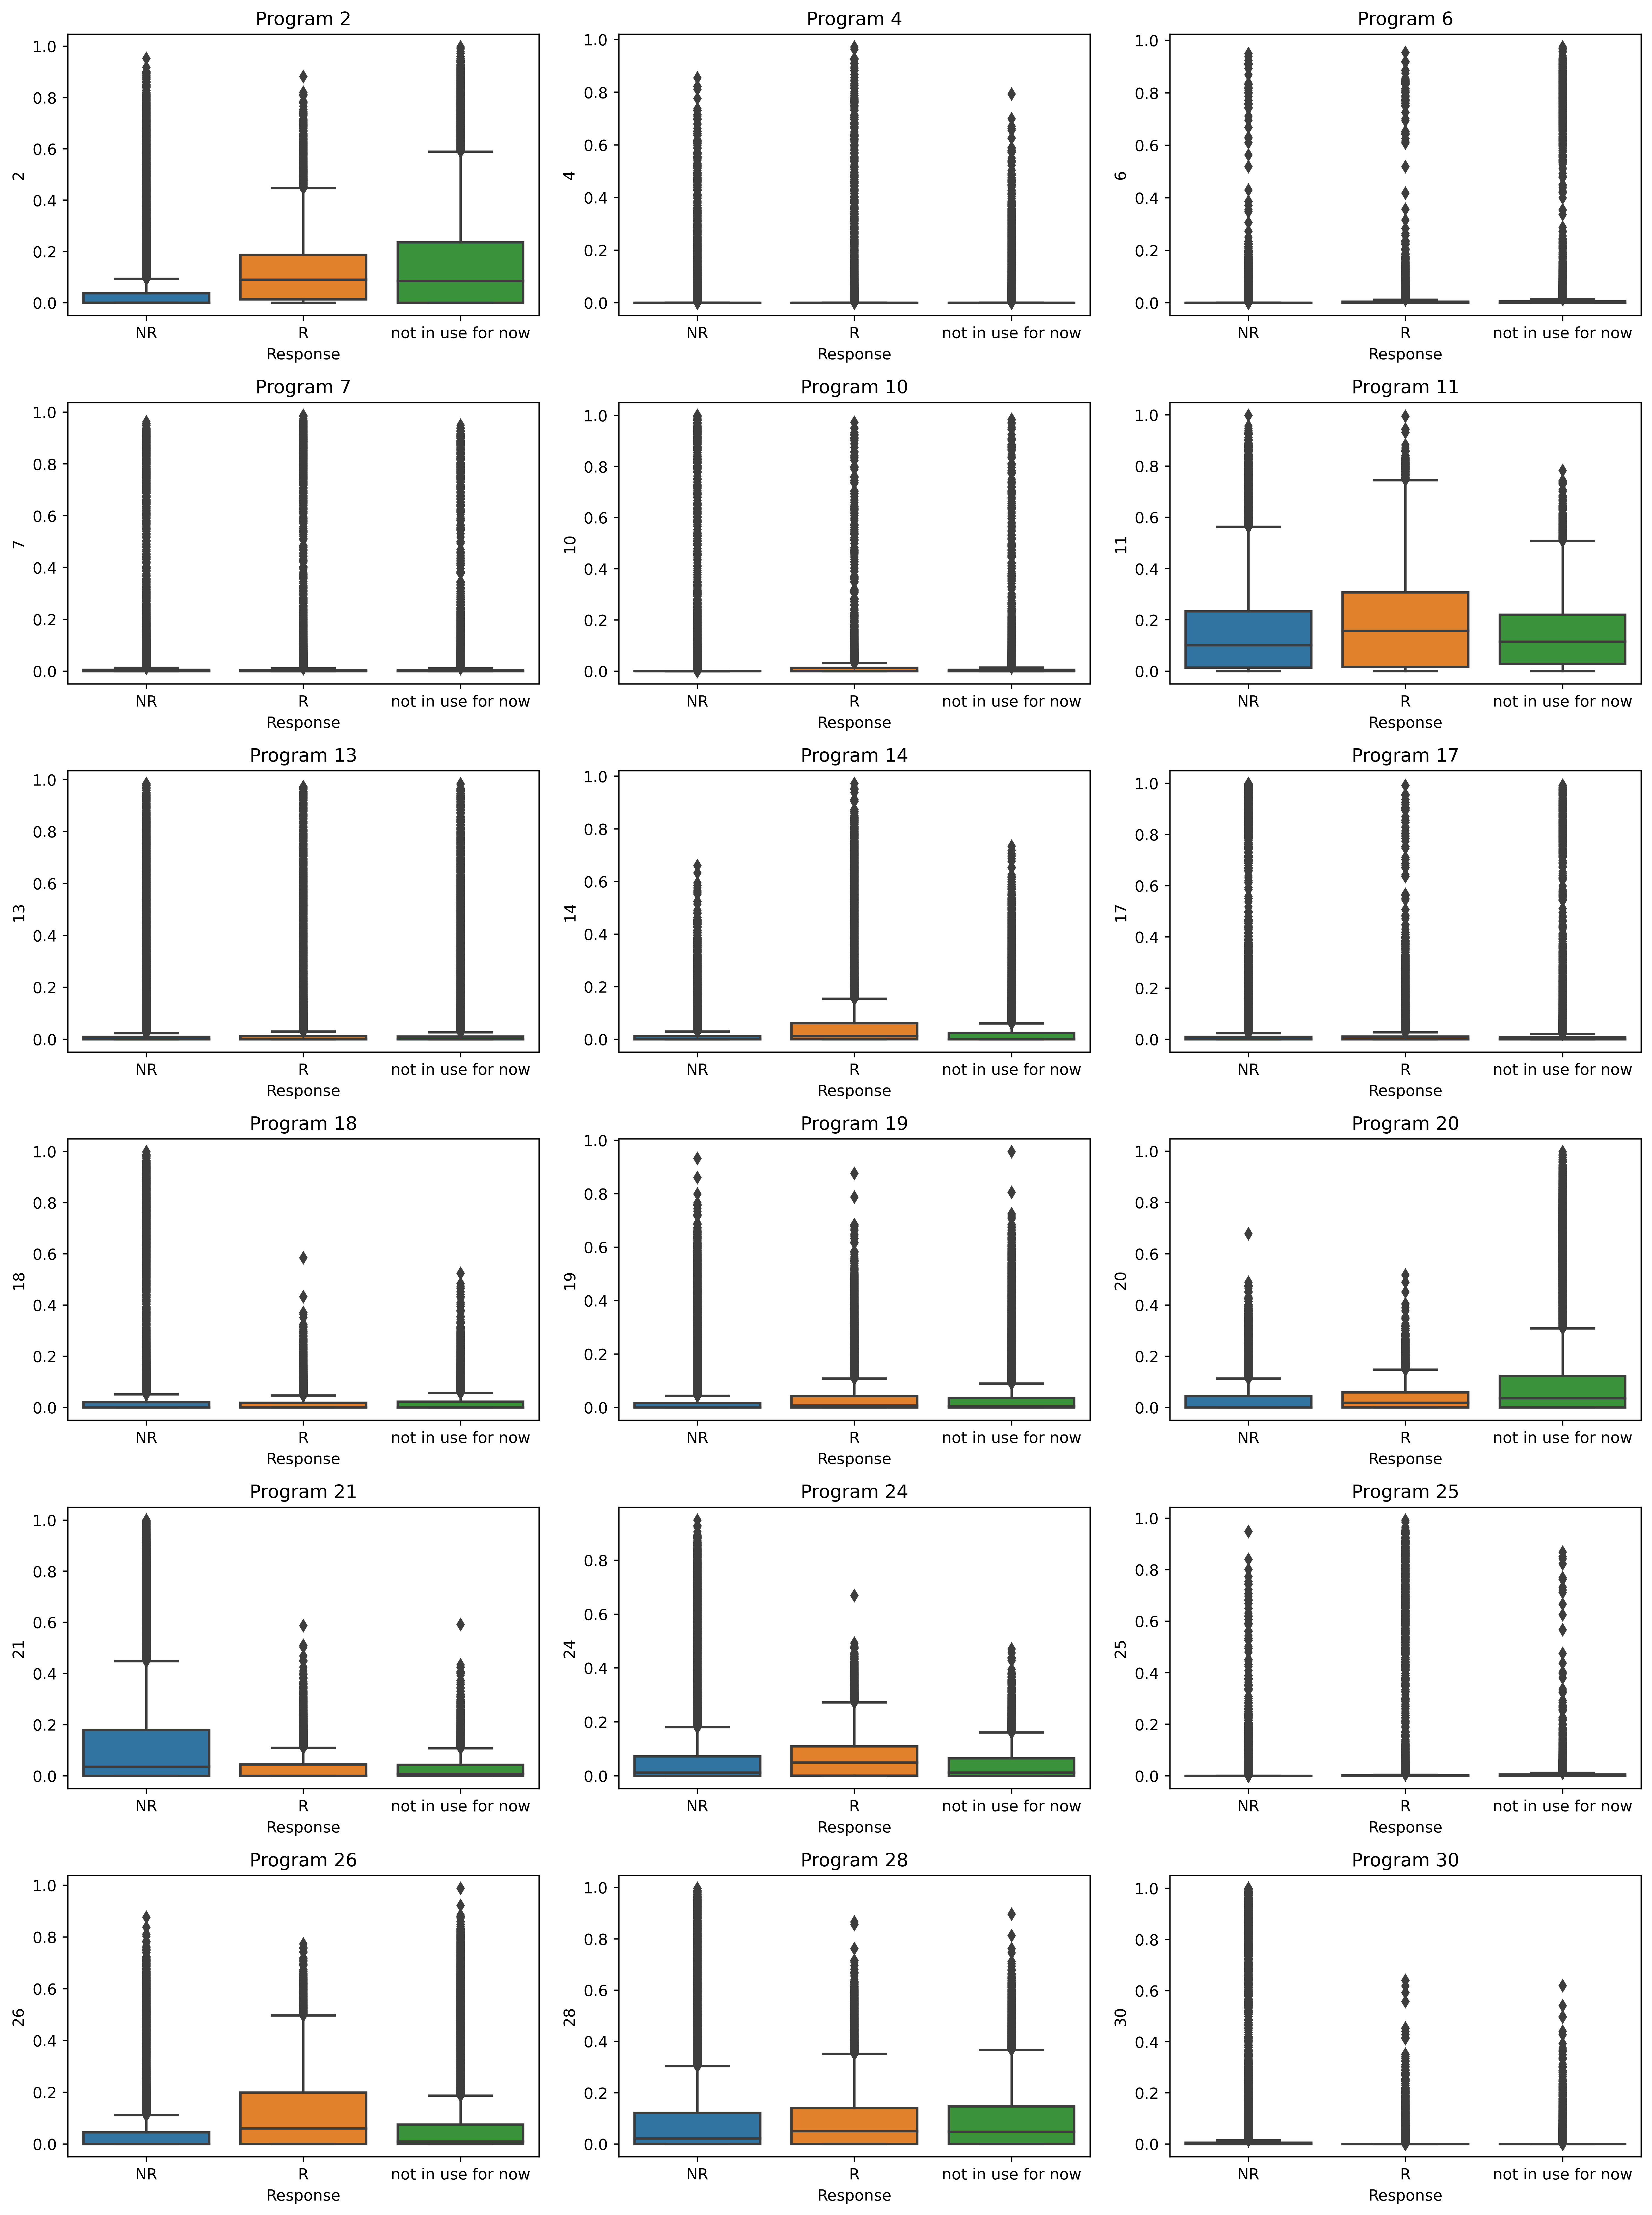

In [18]:
# sns.reset_orig()
import itertools
index = [(x,y) for x in np.arange(11) for y in np.arange(3)]

fig, axs = plt.subplots(int(np.ceil(len(activity_programs_idx)/3)), 3)
fig.set_size_inches(15, 20)
# for i in range(32):
print('Usage distribution of activity programs')
for i, p_idx in enumerate(int_prog_indxes):
    axs[index[i][0], index[i][1]].set_title(f"Program {p_idx+1}")
    sns.boxplot(ax=axs[index[i][0], index[i][1]], y=p_idx+1, x='Response', data=df).set(title=f'Program {p_idx+1}');
plt.tight_layout()


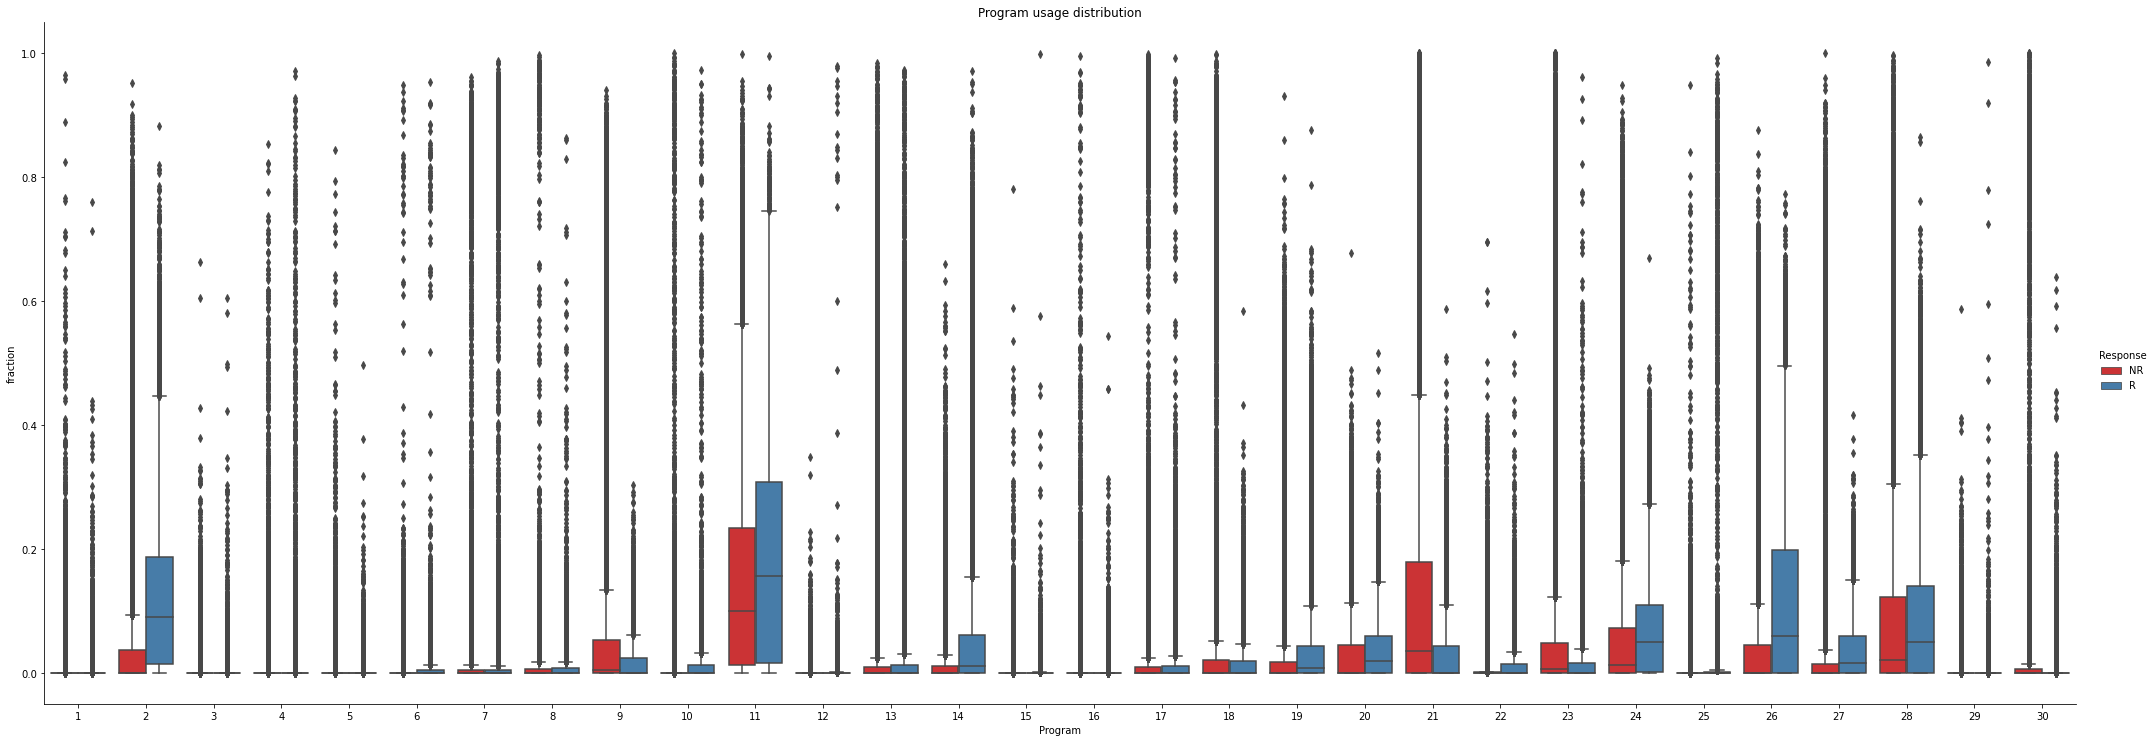

In [20]:
frac_df = df.melt(id_vars=['sample', 'barcode', 'Response'],
        value_vars=list(range(1,N_PROG+1)), var_name ='Program', value_name ='fraction')
frac_df = frac_df[frac_df['Response']!='not in use for now']

sns.reset_orig()
ax = sns.catplot(kind="box", x='Program', y='fraction', hue='Response', data=frac_df, palette="Set1",height=10, aspect=2.9).set(title="Program usage distribution")


And only activity programs:

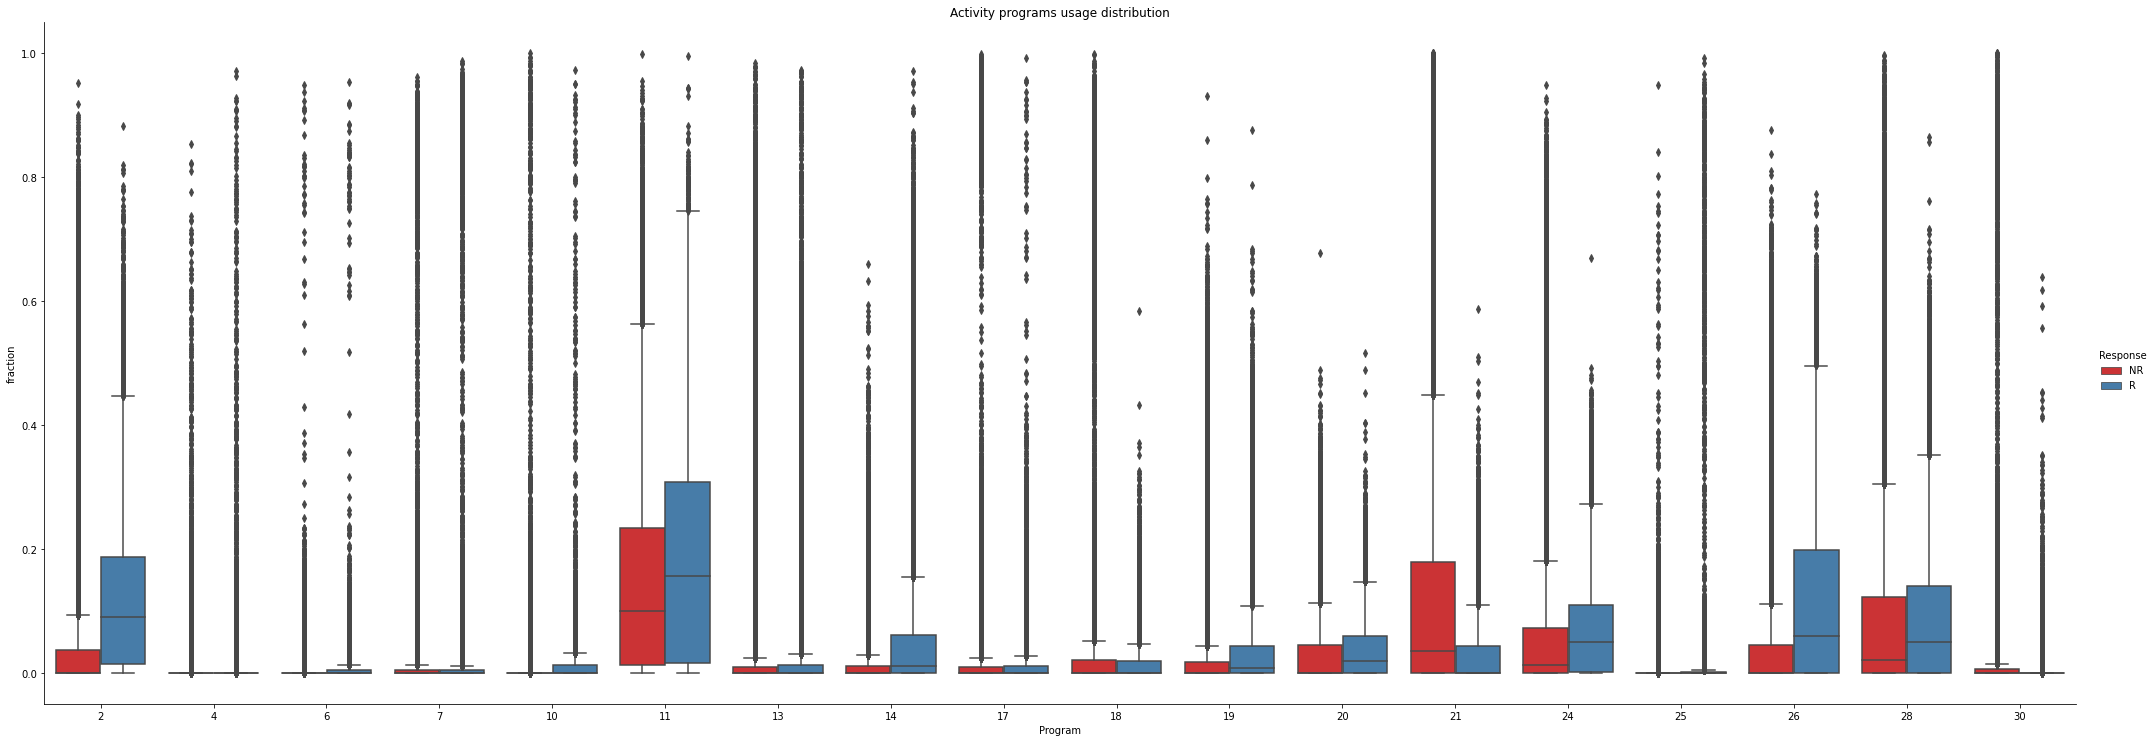

In [21]:
frac_df = frac_df[frac_df['Program'].isin(activity_programs_idx)]
sns.reset_orig()
ax = sns.catplot(kind="box", x='Program', y='fraction', hue='Response', data=frac_df, palette="Set1",height=10, aspect=2.9).set(title="Activity programs usage distribution")


# 4. GEP association with response (2)

Assign each cell one program based on the maximal usage value. Then, for each patient, compute the fraction of cells belonging to each program. Finally, you can perform wilcoxon per program, comparing these fractions between R and NR patients.


###### Loads usages:

In [22]:
EXEC_DIR = r'/storage/md_keren/shitay/outputs/cNMF/executions/tumor_runs/cohort_4.11.21'
selected_K = 30
local_density_threshold = '0.10'
number_of_genes=2000
n_replicates = 200
N_PROG = 30
RUN_RANGE = '30'
RUN_NAME = f'k{RUN_RANGE}_{number_of_genes}genes_{n_replicates}iter'
USAGES_CONSENSUS_FILE = f'{RUN_NAME}.usages.k_{selected_K}.dt_{str(local_density_threshold).replace(".", "_")}.consensus.txt'

usage_matrix = pd.read_csv(join(EXEC_DIR, RUN_NAME, USAGES_CONSENSUS_FILE), sep='\t', index_col=0)
usage_matrix.columns = np.arange(1,selected_K+1)
normalized_usage_matrix = usage_matrix.div(usage_matrix.sum(axis=1), axis=0)
# normalized_usage_matrix.head()

In [23]:
samples = list(set([uu.split('_')[0] for uu in list(normalized_usage_matrix.index)]))
df = normalized_usage_matrix.copy()
df['sample'] = [uu.split('_')[0] for uu in list(df.index)]
df['barcode'] = [uu.split('_')[1] for uu in list(df.index)]
df['Response'] = df['sample'].apply(lambda x: res_melanoma_clinical_data.loc[x]['response'])

df_r = df[df['Response']=='R']
df_nr = df[df['Response']=='NR']

##### Assign each cell one program based on the maximal usage value.

In [25]:
r_high_prog = np.argmax(df_r[list(range(1,N_PROG+1))].values, axis=1)+1
nr_high_prog = np.argmax(df_nr[list(range(1,N_PROG+1))].values, axis=1)+1

df_r['associated program'] = r_high_prog
df_nr['associated program'] = nr_high_prog

<ipython-input-25-64083c8844ce>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_r['associated program'] = r_high_prog
<ipython-input-25-64083c8844ce>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nr['associated program'] = nr_high_prog


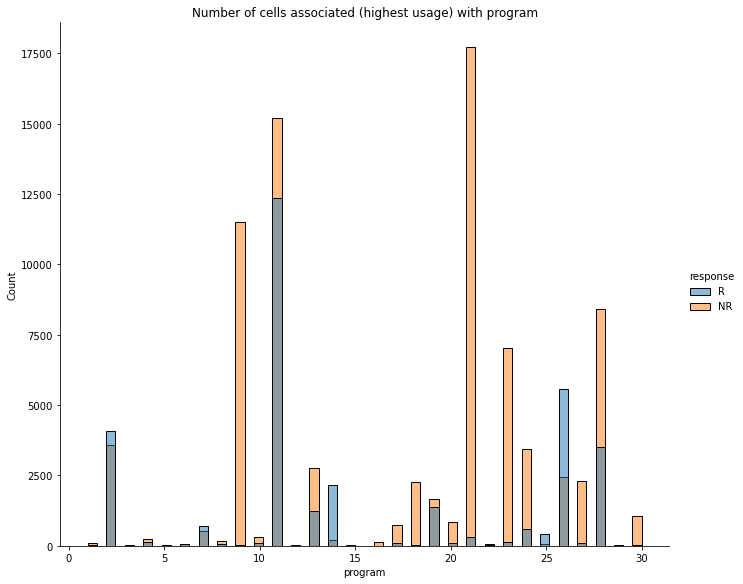

In [26]:
sns.reset_orig() 
ddd = pd.DataFrame(np.concatenate([r_high_prog, nr_high_prog]), columns=['program'])
ddd['response'] = ['R']*len(r_high_prog) + ['NR']*len(nr_high_prog)
sns.displot(data=ddd, x='program', hue='response', common_norm=False,height=8, aspect=1.2).set(title=f'Number of cells associated (highest usage) with program');

Conduct ranksum test:

In [27]:
r_associated_program_count_df = pd.DataFrame(df_r.groupby('sample')['associated program'].value_counts()).rename(columns={'associated program': 'count'}).reset_index()
r_samples = r_associated_program_count_df['sample'].unique()

samples_dic = {}
for sample in r_samples:
#     r_associated_program_count_df[r_associated_program_count_df['sample'==sample]]
    sample_associated_program_df =  r_associated_program_count_df[r_associated_program_count_df['sample']==sample]
    sample_n_barcodes = sum(sample_associated_program_df['count'])
    count_vector = np.zeros(selected_K+1)
    for idx, row in sample_associated_program_df.iterrows():
        count_vector[row['associated program']] = row['count']/sample_n_barcodes
    samples_dic[sample] = count_vector
    
programs_r_patients_usage = {p: [samples_dic[sample][p]  for sample in r_samples] for p in range(1, selected_K+1)}



nr_associated_program_count_df = pd.DataFrame(df_nr.groupby('sample')['associated program'].value_counts()).rename(columns={'associated program': 'count'}).reset_index()
nr_samples = nr_associated_program_count_df['sample'].unique()

samples_dic = {}
for sample in nr_samples:
#     r_associated_program_count_df[r_associated_program_count_df['sample'==sample]]
    sample_associated_program_df =  nr_associated_program_count_df[nr_associated_program_count_df['sample']==sample]
    sample_n_barcodes = sum(sample_associated_program_df['count'])
    count_vector = np.zeros(selected_K+1)
    for idx, row in sample_associated_program_df.iterrows():
        count_vector[row['associated program']] = row['count']/sample_n_barcodes
    samples_dic[sample] = count_vector
    
programs_nr_patients_usage = {p: [samples_dic[sample][p]  for sample in nr_samples] for p in range(1, selected_K+1)}

In [28]:
pvals = np.zeros(selected_K)
for i in range(1, selected_K+1):
    pvals[i-1] = ranksums(programs_nr_patients_usage[i], programs_r_patients_usage[i])[1]

# Correct pvals
pvals = multipletests_fdr(pvals)[1].tolist() 
    
pvals_df = pd.DataFrame([[v[0], int(v[1])] for v in transpose([pvals, range(1, selected_K+1)])], columns=['pval', 'program'])

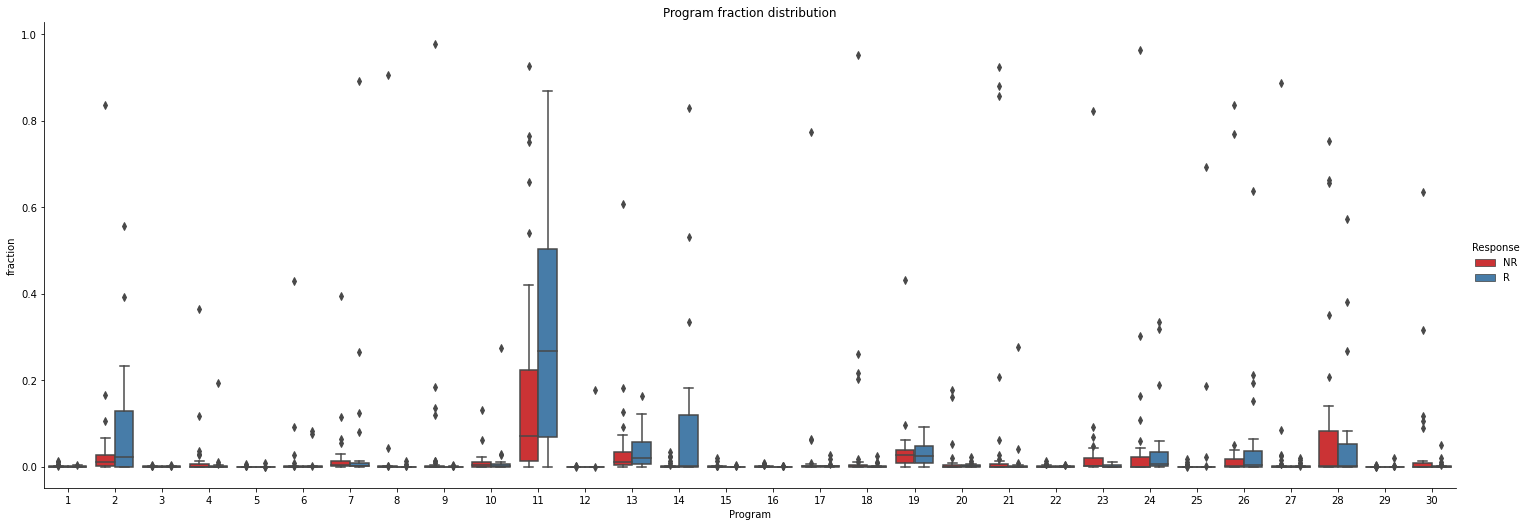

In [29]:
stat_test_prog_frac_df = pd.DataFrame(columns=['Response', 'fraction', 'Program'])

for prog_idx, fraction_list in programs_nr_patients_usage.items():
    for fraction in fraction_list:
        stat_test_prog_frac_df = stat_test_prog_frac_df.append(pd.DataFrame([['NR', fraction, prog_idx]], columns=stat_test_prog_frac_df.columns))
for prog_idx, fraction_list in programs_r_patients_usage.items():
    for fraction in fraction_list:
        stat_test_prog_frac_df = stat_test_prog_frac_df.append(pd.DataFrame([['R', fraction, prog_idx]], columns=stat_test_prog_frac_df.columns))
sns.reset_orig()
ax = sns.catplot(kind="box", x='Program', y='fraction', hue='Response', data=stat_test_prog_frac_df, palette="Set1",height=7, aspect=2.9).set(title="Program fraction distribution")

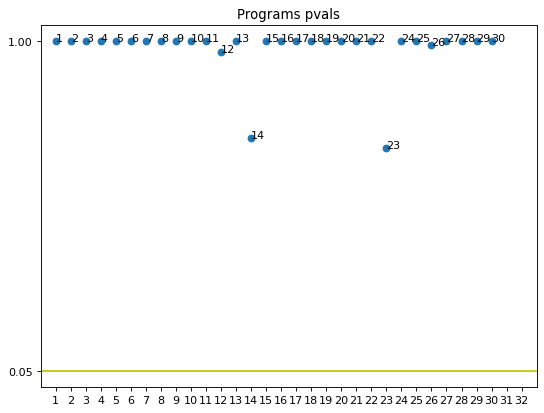

In [30]:
plt.figure(figsize=(8, 6), dpi=80)

pvals = pvals_df[["program", "pval"]].values
small_pvals = pvals[pvals[:,1]<0.05]
big_pvals = pvals[pvals[:,1]>=0.05]


plt.scatter(x=big_pvals[:,0], y=big_pvals[:,1])
plt.scatter(x=small_pvals[:,0], y=small_pvals[:,1])

ax = plt.plot([0,33],[0.05,0.05], color='y')
plt.xticks(np.arange(1, 33));
plt.yticks([0.05, 1]);
plt.xlim((0,33));
plt.title('Programs pvals');

for coord in pvals:
    plt.text(coord[0], coord[1], '{}'.format(int(coord[0])))

Specify program and see the fraction of R/NR sorted:

['NR', 'NR', 'NR', 'NR', 'R', 'R', 'R', 'NR', 'R', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'NR', 'R', 'NR', 'NR', 'R', 'NR', 'R', 'NR', 'R', 'NR', 'NR', 'NR', 'NR', 'R', 'R', 'NR', 'NR', 'NR', 'R', 'NR', 'R', 'NR', 'R', 'R', 'R', 'NR', 'R', 'NR', 'NR', 'R', 'R', 'NR', 'R', 'R', 'NR']


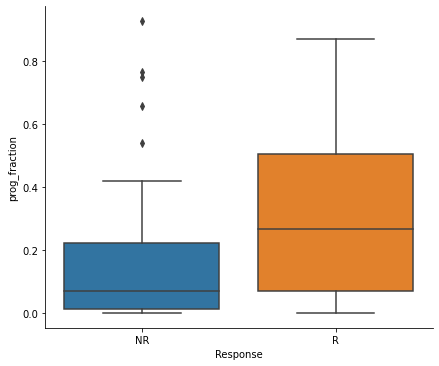

In [34]:
program_idx = 11

patient_fractions = sorted([[x, 'R'] for x in programs_r_patients_usage[program_idx]] + [[x, 'NR'] for x in programs_nr_patients_usage[program_idx]])

sns.reset_orig() # reset size of figure
boxplot_df = pd.DataFrame(patient_fractions, columns=['prog_fraction', 'Response'])
sns.catplot(x="Response", y="prog_fraction", data=boxplot_df, kind="box",height=5, aspect=1.2);


print([x[1] for x in patient_fractions])
# patient_fractions

# Debug

In [5]:
# MARKERS_PATH = r'/storage/md_keren/shitay/Data/tables/ImmuneCellsMarkersUpdated_12.11.20.xlsx'
# pd.read_excel(MARKERS_PATH)
pd.__version__

'1.1.5'

In [1]:
# Loads xlsx files
CLINICAL_LABELS_PATH = r'/storage/md_keren/shitay/Data/tables/clinical_labels.xlsx'
MELANOMA_CLINICAL_DATA_PATH = r'/storage/md_keren/shitay/Data/tables/edited_unprotected_Melanoma_clinical_data.xlsx'
melanoma_clinical_data = pd.read_excel(MELANOMA_CLINICAL_DATA_PATH)
clinical_labels = pd.read_excel(CLINICAL_LABELS_PATH)

# takes nly first 46 samples, fill Nan and creat dictionary mapping
melanoma_clinical_data = melanoma_clinical_data.iloc[:46,:][['Patient id', 'Clinical response', 'Melanoma type']]
melanoma_clinical_data['Clinical response'] = melanoma_clinical_data['Clinical response'].fillna('??')
labels_mapping = {v[0]: v[1] for v in clinical_labels[['Clinical response', 'binary label']].values}

# adds CRITERIA response into clinical df
melanoma_clinical_data['response'] = melanoma_clinical_data['Clinical response'].apply(lambda x: labels_mapping[x])
res_melanoma_clinical_data = melanoma_clinical_data.set_index('Patient id')

NameError: name 'pd' is not defined

In [35]:
def translate(n):
    if n in ['Cutaneous', 'Mucosal ']:
        return n
    else: return 'other'
melanoma_clinical_data3 = melanoma_clinical_data#[melanoma_clinical_data['Melanoma type'].isin(['Cutaneous', 'Mucosal '])]
melanoma_clinical_data3 = melanoma_clinical_data
melanoma_clinical_data3['Melanoma type'] = melanoma_clinical_data3['Melanoma type'].map(lambda x: translate(x))

melanoma_clinical_data.groupby(['Melanoma type', 'response']).count()
melanoma_clinical_data3.groupby(['Melanoma type', 'response']).count().reset_index().drop(columns=['Clinical response']).rename(columns={'Patient id': 'number of samples'})
# set(melanoma_clinical_data['Melanoma type'].tolist())

,Melanoma type,response,number of samples
0,Cutaneous,NR,16
1,Cutaneous,R,9
2,Cutaneous,not in use for now,6
3,Mucosal,NR,5
4,Mucosal,R,2
5,Mucosal,not in use for now,1
6,other,NR,4
7,other,R,3


In [3]:
# melanoma_clinical_data2 = melanoma_clinical_data
# melanoma_clinical_data2

In [36]:

indices = sorted((np.random.rand(1000)*cohort.number_of_cells).astype(int))
# indices

In [37]:
path = r'/storage/md_keren/shitay/garbage/1000_rand_cells.pkl'
pickle.dump(cohort[indices], open(path, 'wb'))

In [15]:
dir_path = r'/storage/md_keren/shitay/outputs/cNMF/executions/tumor_runs/cohort_4.11.21/k10_40_2000genes_20iter/cnmf_tmp'
files = os.listdir(dir_path)

from os.path import join
for file in files:
    ex = join(dir_path, file)
    dis = join(dir_path, file.replace('k10_40', 'k10_35'))
    os.rename(ex, dis)